In [2]:
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import Image, display
from typing import Literal
import os

print("All imports successful")

All imports successful


In [3]:
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found! Please set it in your .env file.")

print("API key loaded")

API key loaded


In [4]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,  
    api_key=openai_api_key
)

print(f"LLM initialized: {llm.model_name}")

LLM initialized: gpt-4o-mini


In [5]:
@tool
def get_weather(city: str) -> str:
    """Get current weather for a given city.
    
    Args:
        city: The city name to get weather for.
        
    Returns:
        Weather information including temperature and conditions.
        
    Example:
        "What's the weather in Lagos?" -> Returns "Current weather in Lagos: Sunny, 28°C"
    """
    weather_data = {
        "lagos": "Sunny, 28°C, humidity: 65%",
        "new york": "Partly cloudy, 15°C, wind: 10 km/h",
        "london": "Rainy, 12°C, chance of rain: 80%",
        "tokyo": "Clear, 22°C, humidity: 50%",
        "sydney": "Windy, 20°C, wind: 25 km/h",
        "paris": "Overcast, 14°C, chance of rain: 30%"
    }
    
    city_lower = city.lower()
    if city_lower in weather_data:
        return f"Current weather in {city.title()}: {weather_data[city_lower]}"
    else:
        return f"Weather simulation for {city.title()}: Mild, 20°C, partly cloudy"

print("Weather tool created")

Weather tool created


In [6]:
@tool
def lookup_word(word: str) -> str:
    """Look up definitions of words in a dictionary.
    
    Args:
        word: The word to look up in the dictionary.
        
    Returns:
        Definition of the word if found, or a message if not found.
        
    Example:
        "Define 'ephemeral'" -> Returns "Definition of 'ephemeral': Lasting for a very short time"
    """
    dictionary = {
        "ephemeral": "Lasting for a very short time; transient.",
        "resilient": "Able to withstand or recover quickly from difficult conditions.",
        "ubiquitous": "Present, appearing, or found everywhere.",
        "paradigm": "A typical example or pattern of something; a model.",
        "serendipity": "The occurrence of events by chance in a happy or beneficial way.",
        "eloquent": "Fluent or persuasive in speaking or writing.",
        "ambiguous": "Open to more than one interpretation; not having one obvious meaning.",
        "diligent": "Having or showing care in one's work or duties.",
        "verbose": "Using more words than needed; wordy.",
        "conundrum": "A confusing and difficult problem or question."
    }
    
    word_lower = word.lower()
    if word_lower in dictionary:
        return f"Definition of '{word}': {dictionary[word_lower]}"
    else:
        return f"Word '{word}' not found in dictionary. Please try another word."

print(" Dictionary tool created")

 Dictionary tool created


In [7]:
@tool
def web_search(query: str) -> str:
    """Search the web for current information using DuckDuckGo.
    
    Args:
        query: The search query to look up on the web.
        
    Returns:
        Search results with titles and snippets from DuckDuckGo.
        
    Example:
        "Search for latest AI news" -> Returns search results about AI news
    """
    try:
        from duckduckgo_search import DDGS
        
        with DDGS() as ddgs:
            results = []
            for r in ddgs.text(query, max_results=3):
                results.append(f"Title: {r['title']}\nSnippet: {r['body']}\n")
            
            if results:
                return f"Search results for '{query}':\n\n" + "\n---\n".join(results)
            else:
                return f"No results found for '{query}'"
    except Exception as e:
        return f"Error performing web search: {str(e)}"

print("Web search tool created")

Web search tool created


In [8]:
tools = [get_weather, lookup_word, web_search]
llm_with_tools = llm.bind_tools(tools)

print(f"LLM bound to {len(tools)} tools")
print(f"   Tools: {[tool.name for tool in tools]}")

LLM bound to 3 tools
   Tools: ['get_weather', 'lookup_word', 'web_search']


In [9]:
sys_msg = SystemMessage(content="""You are a helpful assistant with access to tools.

When asked about weather in a city, use the get_weather tool.
When asked for word definitions, use the lookup_word tool.
When asked for current information, news, or facts that require searching, use the web_search tool.

Only use tools when necessary - for general knowledge questions you know, answer directly.""")

def assistant(state: MessagesState) -> dict:
    messages = [sys_msg] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

print("Assistant node defined")

Assistant node defined


In [11]:
def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    last_message = state["messages"][-1]
    
    if last_message.tool_calls:
        return "tools"
    
    return "__end__"

print("Conditional routing function defined")

Conditional routing function defined


In [12]:
builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    should_continue,
    {"tools": "tools", "__end__": END}
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
agent = builder.compile(checkpointer=memory)

print("Agent graph compiled with tools and memory")

Agent graph compiled with tools and memory


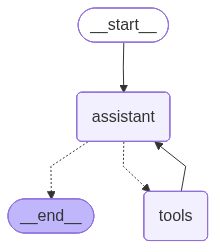

In [14]:
try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph structure: START → assistant → [conditional] → tools → assistant → END")

In [ ]:
def real_time_conversation():
    """Run a real-time conversation with the tool-using agent"""
    print("\n" + "="*70)
    print(" TOOL-USING AGENT - Real-time Conversation")
    print("="*70)
    print("Type 'exit' to end the conversation")
    print("Type 'new' to start a new conversation with a different thread")
    print("="*70)
    
    thread_id = "conv_001"
    conversation_counter = 1
    
    while True:
        user_input = input(f"\n[{thread_id}] You: ").strip()
        
        
        if user_input.lower() == 'exit':
            print("\nGoodbye! ")
            break
        
        
        if user_input.lower() == 'new':
            conversation_counter += 1
            thread_id = f"conv_{conversation_counter:03d}"
            print(f"\n Starting new conversation with thread ID: {thread_id}")
            continue
        
                
        
        if not user_input:
            print("Please enter a message.")
            continue
        
        
        try:
            print("\n" + "="*70)
            print(f" Processing query...")
            print("="*70)
            
            
            result = agent.invoke(
                {"messages": [HumanMessage(content=user_input)]},
                config={"configurable": {"thread_id": thread_id}}
            )
            
            
            last_message = result["messages"][-1]
            
            if isinstance(last_message, AIMessage):
                if last_message.tool_calls:
                    
                    for message in result["messages"]:
                        if isinstance(message, AIMessage) and message.tool_calls:
                            tool_call = message.tool_calls[0]
                            print(f" Agent: [Calling {tool_call['name']} with: {tool_call['args']}]")
                        elif isinstance(message, ToolMessage):
                            content = message.content
                            if len(content) > 150:
                                content = content[:150] + "..."
                            print(f" Tool Result: {content}")
                        elif isinstance(message, AIMessage) and not message.tool_calls:
                            print(f" Agent: {message.content}")
                else:
                    print(f" Agent: {last_message.content}")
            
            print("\n" + "="*70)
            
        except Exception as e:
            print(f"\n Error: {e}")
            print("Please try again or type 'exit' to quit.")

real_time_conversation()


 TOOL-USING AGENT - Real-time Conversation
Type 'exit' to end the conversation
Type 'new' to start a new conversation with a different thread
Type 'test' to run pre-defined tests

 Processing query...
 Agent: Hello! How can I assist you today?


 Processing query...
 Agent: The current weather in Abeokuta is mild, with a temperature of 20°C and partly cloudy conditions.


 Processing query...
 Agent: The longest word in the dictionary is often cited as "pneumonoultramicroscopicsilicovolcanoconiosis," which is a lung disease caused by inhaling very fine silicate or quartz dust. It has 45 letters. However, there are even longer technical or coined words that are not commonly used in everyday language.


 Processing query...
 Agent: The word "ephemeral" is defined as lasting for a very short time; transient.


Goodbye! 
